## Noisy RGB pixels, Conv + ResUNet + Conv, Fit Residual, L1+L2+Perceptual loss, 1/8 U-Net bottleneck

In [6]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    return {
        'w': w,
        'h': h,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


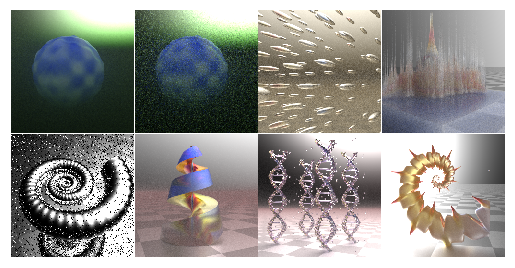

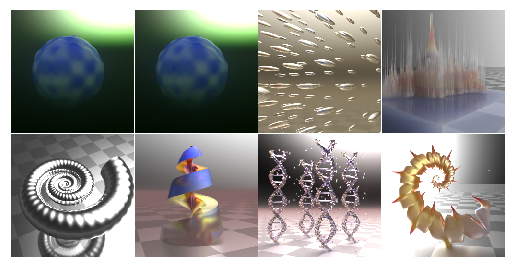

In [8]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [9]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)

    def forward(self, input):
        ci = self.convi(input)
        e0 = self.econv0b(relu(self.econv0a(relu(ci)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.convo(ci+do)


model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(1, 1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
128 0.1013159528374672
256 0.10733707249164581
384 0.0784711241722107
512 0.10309596359729767
640 0.10538157820701599
768 0.06695377826690674
896 0.08199742436408997
1024 0.0554252527654171
1152 0.057981278747320175
1280 0.045773979276418686
1408 0.04148954153060913
1536 0.07948054373264313
1664 0.0447656586766243
1792 0.029371125623583794
1920 0.06165516376495361
2048 0.023854579776525497


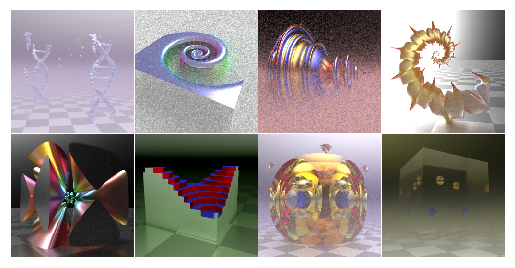

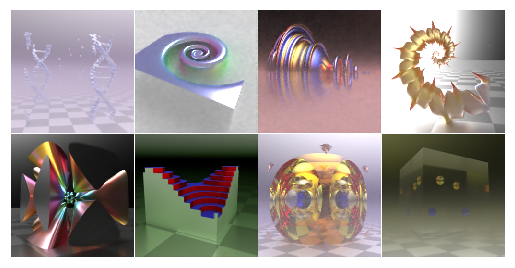

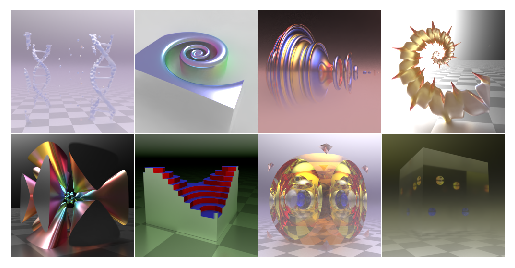

2176 0.06332772225141525
2304 0.035709504038095474
2432 0.05431770533323288
2560 0.08000203967094421
2688 0.05007046461105347
2816 0.05876270681619644
2944 0.06117954105138779
3072 0.09101790189743042
3200 0.03690221533179283
3328 0.033504702150821686
3456 0.08328886330127716
3584 0.05862211808562279
3712 0.037277162075042725
3840 0.028786515817046165
3968 0.02456902712583542
4096 0.04017248749732971


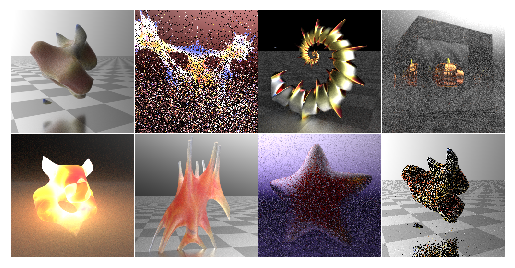

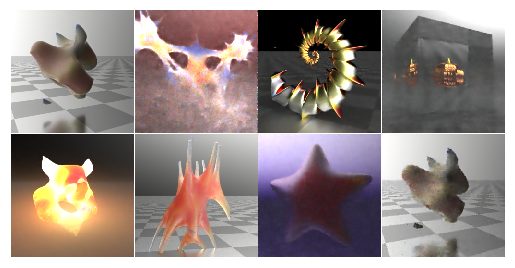

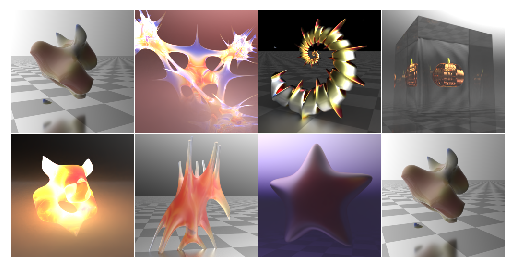

4224 0.04999128729104996
4352 0.08120989799499512
4480 0.020574210211634636
4608 0.0514645017683506
4736 0.04133336618542671
4864 0.07161898165941238
4992 0.06388068199157715
5120 0.023572757840156555
5248 0.06168301776051521
5376 0.06686252355575562
5504 0.06144663691520691
5632 0.04398340731859207
5760 0.016674017533659935
5888 0.057440780103206635
6016 0.036879681050777435
6144 0.09693748503923416


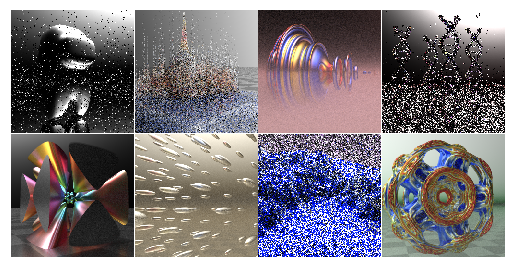

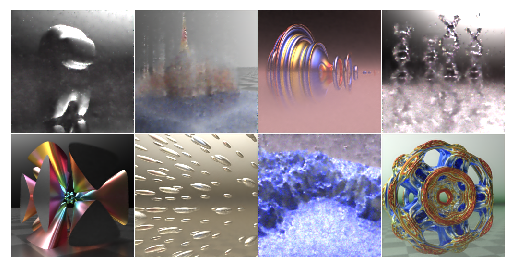

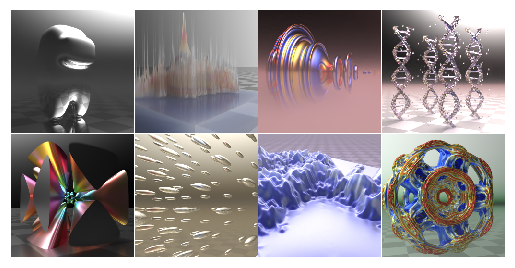

6272 0.056444741785526276
6400 0.046812839806079865
6528 0.06706292927265167
6656 0.03195774927735329
6784 0.03730003535747528
6912 0.018945980817079544
7040 0.03392142802476883
7168 0.02260594442486763
7296 0.03373018652200699
7424 0.03690601885318756
7552 0.016104592010378838
7680 0.03007383644580841
7808 0.03276202082633972
7936 0.03505334258079529
8064 0.03488009795546532
8192 0.05071213096380234


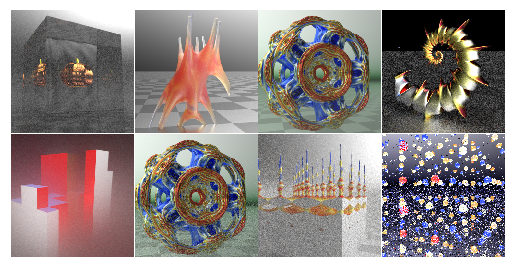

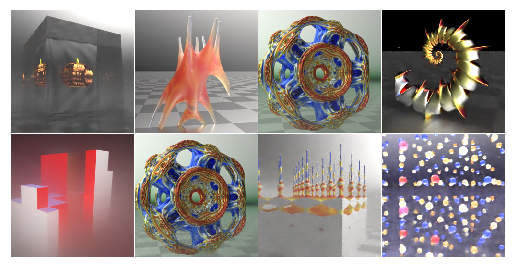

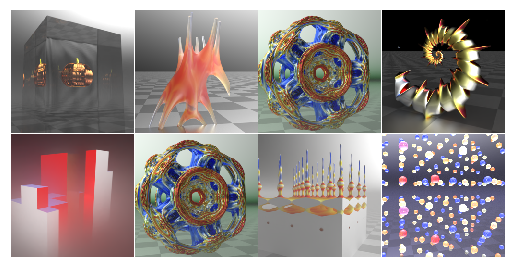

8320 0.02082117833197117
8448 0.05133094638586044
8576 0.025517739355564117
8704 0.056482356041669846
8832 0.0337967723608017
8960 0.0444532074034214
9088 0.03683030605316162
9216 0.046397048979997635
9344 0.03506813198328018
9472 0.08511428534984589
9600 0.0674978643655777
9728 0.05113482475280762
9856 0.052919596433639526
9984 0.06912298500537872
10112 0.06802297383546829
10240 0.07133749127388
Epoch 00080: reducing learning rate of group 0 to 1.0000e-04.


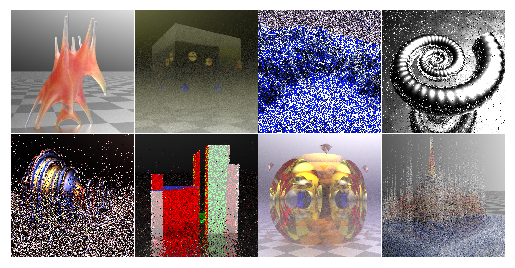

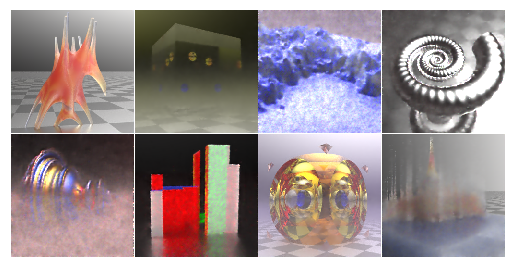

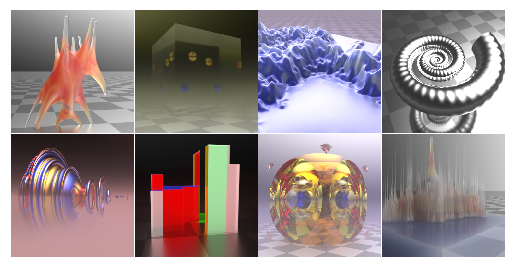

10368 0.03327218443155289
10496 0.04350750148296356
10624 0.05566985532641411
10752 0.056446291506290436
10880 0.04459777846932411
11008 0.01745983585715294
11136 0.04604858160018921
11264 0.041023287922143936
11392 0.046139996498823166
11520 0.04733261466026306
11648 0.039960332214832306
11776 0.0352669283747673
11904 0.01886928640305996
12032 0.04375408589839935
12160 0.026885485276579857
12288 0.03155599534511566


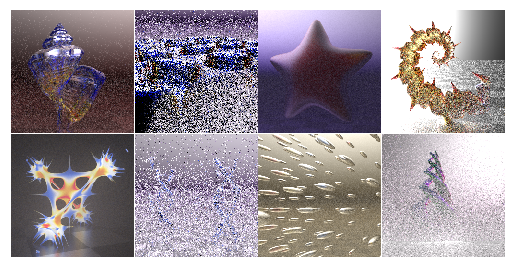

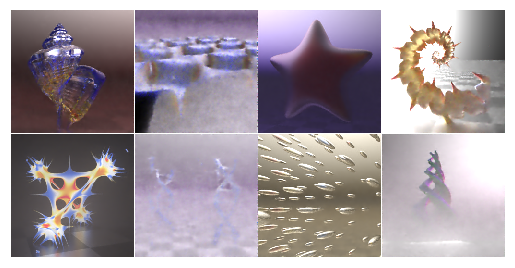

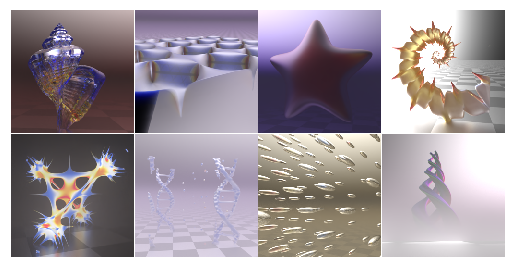

12416 0.0459432452917099
12544 0.03234416991472244
12672 0.05465616285800934
12800 0.03546863794326782
12928 0.017562441527843475
Epoch 00101: reducing learning rate of group 0 to 1.0000e-05.
13056 0.025569206103682518
13184 0.02554105967283249
13312 0.018109219148755074
13440 0.02712264098227024
13568 0.025268061086535454
13696 0.04814823344349861
13824 0.044951461255550385
13952 0.036039188504219055
14080 0.025962352752685547
14208 0.034175071865320206
14336 0.05810780078172684


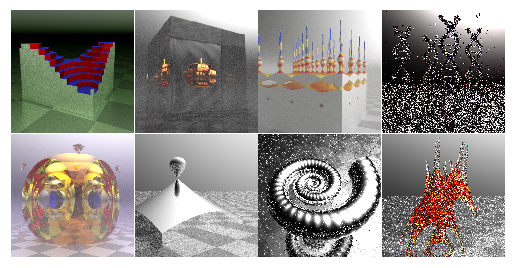

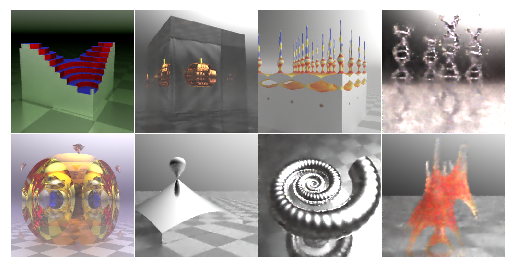

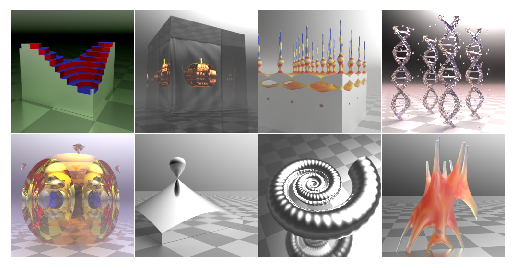

14464 0.020907560363411903
14592 0.013446968980133533
14720 0.04631326347589493
14848 0.024272819980978966
14976 0.028812484815716743
15104 0.024943334981799126
15232 0.051492515951395035
15360 0.025387601926922798
15488 0.01625926047563553
15616 0.027471719309687614
15744 0.04572485387325287
15872 0.03744731470942497
16000 0.01848076470196247
16128 0.018585918471217155
16256 0.03705945238471031
16384 0.02662513591349125


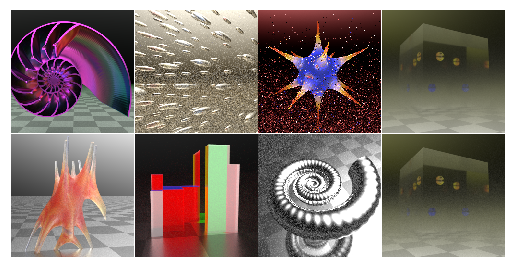

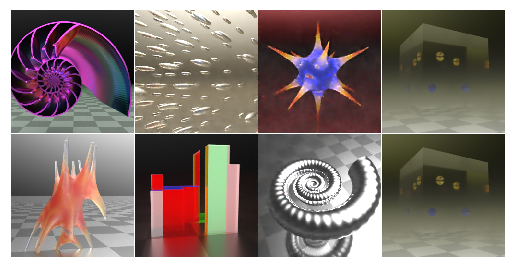

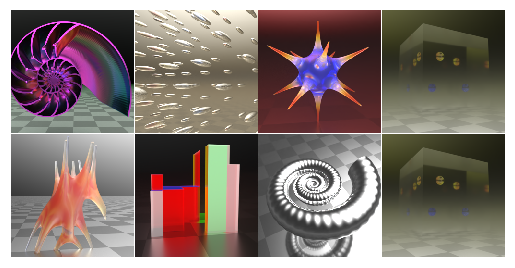

16512 0.015060140751302242
16640 0.03219524025917053
16768 0.0466437004506588
16896 0.01983705908060074
17024 0.01605387218296528
17152 0.030632004141807556
17280 0.0455695241689682
Epoch 00135: reducing learning rate of group 0 to 1.0000e-06.
17408 0.024011939764022827
17536 0.02879258617758751
17664 0.0338781401515007
17792 0.041723866015672684
17920 0.02746763452887535
18048 0.020700912922620773
18176 0.02515527978539467
18304 0.03691231459379196
18432 0.04059157520532608


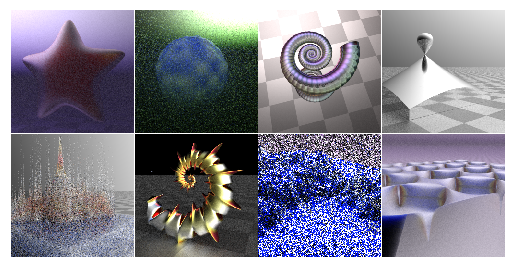

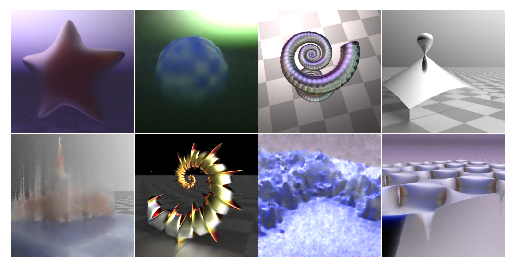

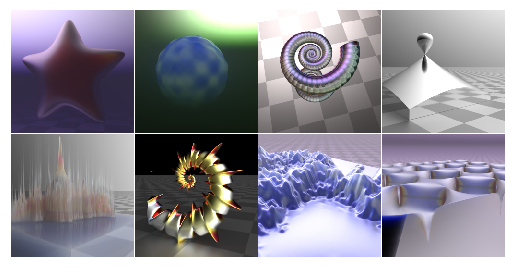

18560 0.04886079579591751
18688 0.03149157389998436
18816 0.03608317673206329
18944 0.027746355161070824
19072 0.032156143337488174
19200 0.020262274891138077
19328 0.02896970883011818
19456 0.01130660343915224
19584 0.048595964908599854
19712 0.02400926686823368
19840 0.03144126012921333
19968 0.019322020933032036
20096 0.019613992422819138
20224 0.03450869768857956
20352 0.01318441517651081
20480 0.022398624569177628


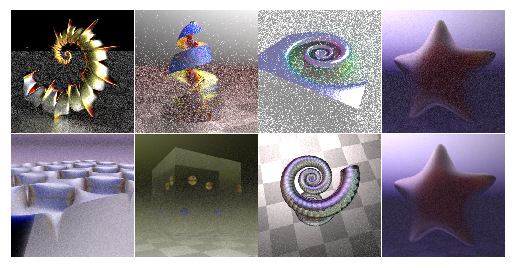

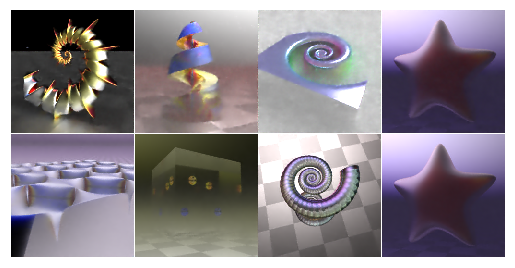

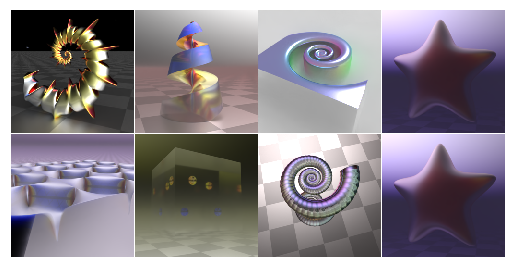

20608 0.02651244029402733
20736 0.020790036767721176
20864 0.02714141085743904
20992 0.03621778264641762
21120 0.03154837340116501
21248 0.04976203292608261
21376 0.012208279222249985
21504 0.02659529820084572
21632 0.05104232579469681
21760 0.03615962713956833
21888 0.015077797695994377
22016 0.04024039953947067
22144 0.027095766738057137
Epoch 00173: reducing learning rate of group 0 to 1.0000e-07.


In [10]:
import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
vgg16_head = vgg16_features[:4].to(device)
for param in vgg16_head:
    param.requires_grad = False
print(vgg16_head)

def lossfun(output, reference):
    l1 = torch.mean(torch.abs(output-reference))
    l2 = torch.mean((output-reference)**2) / 0.05
    output1 = vgg16_head(output)
    reference1 = vgg16_head(reference)  # to do: can be precomputed
    lp = torch.mean(torch.abs(output1-reference1))
    return l1 + l2 + lp

model_params = torch.cat([x.view(-1) for x in model.parameters()])

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=20, min_lr=0.0, verbose=True)


batch_count = 0
terminate = False
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        output = model(x)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        loss.backward()
        # regl1 = 0.0 * torch.mean(torch.abs(model_params))
        # regl2 = 1.0 * torch.mean((model_params)**2)
        # (regl1+regl2).backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
            scheduler.step(loss)
            if optimizer.param_groups[0]['lr'] < 1e-6:
                terminate = True
                break
        if batch_count % 2048 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)
            model_path = "model5_small.pth"
            torch.save(model, model_path)
    if terminate:
        break

torch.save(model, model_path)
